In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("DEXTAUS.csv")
df.head()

,DATE,DEXTAUS
0,2010-10-12,30.9800
1,2010-10-13,30.8400
2,2010-10-14,30.6600
3,2010-10-15,30.6600
4,2010-10-18,30.7500


In [3]:
df.shape

(2609, 2)

In [4]:
df = df[~df['DEXTAUS'].isin(["."])]

In [5]:
df.shape

(2504, 2)

In [6]:
df["DEXTAUS"] = df["DEXTAUS"].astype(float)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

findfont: Font family ['Microsoft JhengHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Microsoft JhengHei'] not found. Falling back to DejaVu Sans.


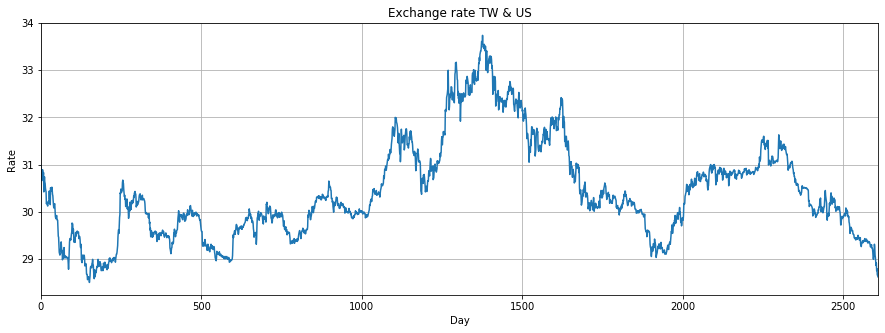

In [9]:
plt.title('Exchange rate TW & US')
plt.ylabel('Rate')
plt.xlabel('Day')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['DEXTAUS'])

In [10]:
rate = df.DEXTAUS.values
rate

array([30.98, 30.84, 30.66, ..., 28.66, 28.65, 28.62])

In [11]:
#決定訓練集與測試集大小
test_data_size = 504

train_data = rate[:-test_data_size]
test_data = rate[-test_data_size:]

In [12]:
print(len(train_data))
print(len(test_data))

2000
504


In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [14]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.05343511]
 [-0.10687023]
 [-0.17557252]
 [-0.17557252]
 [-0.14122137]]
[[-0.17938931]
 [-0.22900763]
 [-0.2519084 ]
 [-0.22137405]
 [-0.21755725]]


In [15]:
import torch
import torch.nn as nn
import numpy as np

In [16]:
#torch.cuda.is_available()

In [16]:
#轉換為張量
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [17]:
#30天一循環
train_cicle = 30 

In [18]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [19]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_cicle)

In [20]:
train_inout_seq[:5]

[(tensor([-0.0534, -0.1069, -0.1756, -0.1756, -0.1412, -0.0878, -0.1107, -0.1450,
          -0.1107, -0.2672, -0.1794, -0.1450, -0.1870, -0.1985, -0.2366, -0.2557,
          -0.2672, -0.3626, -0.3550, -0.3588, -0.3740, -0.3817, -0.3435, -0.3550,
          -0.3321, -0.2595, -0.3244, -0.3244, -0.3702, -0.2328]),
  tensor([-0.2595])),
 (tensor([-0.1069, -0.1756, -0.1756, -0.1412, -0.0878, -0.1107, -0.1450, -0.1107,
          -0.2672, -0.1794, -0.1450, -0.1870, -0.1985, -0.2366, -0.2557, -0.2672,
          -0.3626, -0.3550, -0.3588, -0.3740, -0.3817, -0.3435, -0.3550, -0.3321,
          -0.2595, -0.3244, -0.3244, -0.3702, -0.2328, -0.2595]),
  tensor([-0.2519])),
 (tensor([-0.1756, -0.1756, -0.1412, -0.0878, -0.1107, -0.1450, -0.1107, -0.2672,
          -0.1794, -0.1450, -0.1870, -0.1985, -0.2366, -0.2557, -0.2672, -0.3626,
          -0.3550, -0.3588, -0.3740, -0.3817, -0.3435, -0.3550, -0.3321, -0.2595,
          -0.3244, -0.3244, -0.3702, -0.2328, -0.2595, -0.2519]),
  tensor([-0.2290]))

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

        
    def forward(self, input_seq):
        
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        
        return predictions[-1]

In [22]:
#optimizer
model = LSTM()
#model.cuda()

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [24]:
epochs = 100

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00182106
epoch:  26 loss: 0.00036871
epoch:  51 loss: 0.00012644
epoch:  76 loss: 0.00008551
epoch:  99 loss: 0.0000364054


In [25]:
fut_pred = 504

test_inputs = train_data_normalized[-train_cicle:].tolist()
print(test_inputs)

[-0.16030533611774445, -0.17557251453399658, -0.11832061409950256, -0.17557251453399658, -0.1679389327764511, -0.18320611119270325, -0.1564885526895523, -0.14885495603084564, -0.16030533611774445, -0.12595419585704803, -0.12595419585704803, -0.12977099418640137, -0.1335877925157547, -0.10687022656202316, -0.11832061409950256, -0.1450381726026535, -0.12595419585704803, -0.1335877925157547, -0.1335877925157547, -0.12595419585704803, -0.14122137427330017, -0.13740457594394684, -0.17938931286334991, -0.16412213444709778, -0.17557251453399658, -0.17938931286334991, -0.22900763154029846, -0.25190839171409607, -0.221374049782753, -0.21755725145339966]


In [49]:
#test_inputs

In [26]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_cicle:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        print(model(seq))
        test_inputs.append(model(seq).item())

tensor([-0.2197])
tensor([-0.2223])
tensor([-0.2245])
tensor([-0.2266])
tensor([-0.2287])
tensor([-0.2307])
tensor([-0.2327])
tensor([-0.2346])
tensor([-0.2364])
tensor([-0.2380])
tensor([-0.2396])
tensor([-0.2410])
tensor([-0.2423])
tensor([-0.2435])
tensor([-0.2446])
tensor([-0.2455])
tensor([-0.2464])
tensor([-0.2472])
tensor([-0.2480])
tensor([-0.2487])
tensor([-0.2493])
tensor([-0.2499])
tensor([-0.2504])
tensor([-0.2509])
tensor([-0.2513])
tensor([-0.2518])
tensor([-0.2521])
tensor([-0.2525])
tensor([-0.2528])
tensor([-0.2531])
tensor([-0.2534])
tensor([-0.2536])
tensor([-0.2538])
tensor([-0.2540])
tensor([-0.2541])
tensor([-0.2543])
tensor([-0.2544])
tensor([-0.2545])
tensor([-0.2546])
tensor([-0.2547])
tensor([-0.2548])
tensor([-0.2549])
tensor([-0.2550])
tensor([-0.2550])
tensor([-0.2551])
tensor([-0.2551])
tensor([-0.2551])
tensor([-0.2552])
tensor([-0.2552])
tensor([-0.2552])
tensor([-0.2553])
tensor([-0.2553])
tensor([-0.2553])
tensor([-0.2553])
tensor([-0.2553])
tensor([-0

In [27]:
test_inputs[fut_pred:]

[-0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516,
 -0.2554244101047516]

In [28]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_cicle:] ).reshape(-1, 1))
#actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_cicle:] ).reshape(-1, 1))
print(actual_predictions)

[[30.54327237]
 [30.53755301]
 [30.53171302]
 [30.52633199]
 [30.5209138 ]
 [30.51552629]
 [30.51032306]
 [30.50536367]
 [30.50069491]
 [30.49634613]
 [30.4923167 ]
 [30.48860687]
 [30.48521584]
 [30.48212465]
 [30.47928621]
 [30.47669919]
 [30.47435665]
 [30.47222251]
 [30.47028264]
 [30.46851002]
 [30.46687616]
 [30.46536675]
 [30.46396572]
 [30.46268971]
 [30.46150973]
 [30.46041377]
 [30.4593962 ]
 [30.45847726]
 [30.45764154]
 [30.45688868]
 [30.45621202]
 [30.45560524]
 [30.45506202]
 [30.45457682]
 [30.45414386]
 [30.45375805]
 [30.45341449]
 [30.4531088 ]
 [30.45283723]
 [30.45259596]
 [30.45238178]
 [30.45219173]
 [30.4520233 ]
 [30.45187401]
 [30.45174197]
 [30.45162509]
 [30.45152178]
 [30.45143058]
 [30.45135016]
 [30.45127918]
 [30.45121672]
 [30.45116175]
 [30.45111357]
 [30.45107117]
 [30.45103416]
 [30.45100183]
 [30.45097341]
 [30.45094874]
 [30.45092711]
 [30.45090829]
 [30.45089189]
 [30.45087768]
 [30.45086535]
 [30.45085465]
 [30.45084536]
 [30.45083732]
 [30.45083

In [29]:
x = np.arange(2000, 2504, 1)
print(x)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027
 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041
 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055
 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069
 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083
 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097
 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108 2109 2110 2111
 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122 2123 2124 2125
 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139
 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153
 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164 2165 2166 2167
 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178 2179 2180 2181
 2182 2183 2184 2185 2186 2187 2188 2189 2190 2191 2192 2193 2194 2195
 2196 

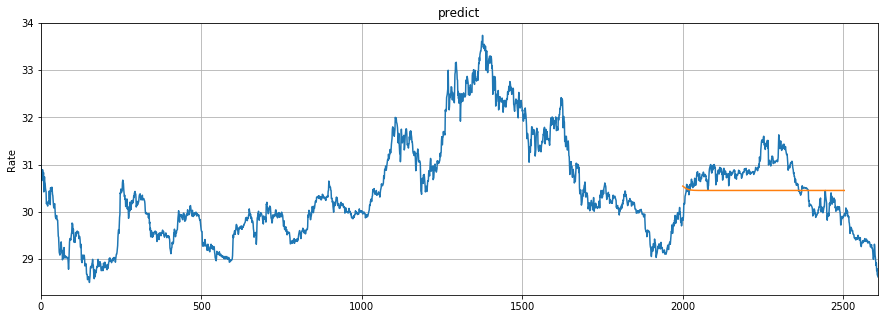

In [30]:
plt.title('predict')
plt.ylabel('Rate')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['DEXTAUS'])
plt.plot(x, actual_predictions)
plt.show()